# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [3]:
import time
start = time.time()

import sys
sys.path.append('../../ABEL/')
from abel import *
end = time.time()
print(end-start, ' sek')

%load_ext autoreload
%autoreload 2

34.31964612007141  sek


In [4]:
import numpy as np
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp
import scipy.special as sc
import matplotlib.pyplot as plt

### Define the linac and beams

In [45]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]
driver.symmetrize = True
driver.x_offset = 0.5e-6
driver.seed = 5
#drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######


# define stage
stage = StageQuasistatic2d()
#stage = StagePrtclTransWakeInstability()                      #######
#stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.length = 100 # [m]
stage.nom_energy_gain = 0#31.9e9*(stage.length/11) # [eV]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_radiation_reaction = True
stage.save_evolution = True
if stage.enable_radiation_reaction == False:
    stage.save_evolution = False

# define first stage (half length)
first_stage = StageQuasistatic2d()
#first_stage = StagePrtclTransWakeInstability()                      #######
#first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_radiation_reaction = stage.enable_radiation_reaction
first_stage.save_evolution = stage.save_evolution

# define beam
source = SourceBasic()
source.charge = -5e5 * SI.e # [C]
energy = 10440
source.energy = energy*1e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.0
source.bunch_length = 0.1e-6 # [m]
source.z_offset = 28e-6 #0 [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
source.jitter.t = driver.jitter.t
source.symmetrize = True
source.seed = driver.seed
#beam = source.track()

"""
main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]
"""
# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
#linac.first_stage = first_stage
#linac.interstage = interstage
linac.num_stages: int = 1
shots = 1

### Run simulations

In [47]:
start = time.time()
linac.run(f'linac_example_new_solver_RR_{stage.enable_radiation_reaction}\
_stages_{linac.num_stages}', num_shots=shots, overwrite=True, parallel=False);
end = time.time()

print((end - start)/60, ' min') # time in minutes

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 10440.0 GeV, -0.00 nC, 0.0% rms, 160.7/0.6 µm-rad)
Tracking element 2 (StageQuasistatic2d, stage 1, s = 100.0 m, 10450.0 GeV, -0.00 nC, 2.6% rms, 156.8/0.5 µm-rad)
0.5810188293457031  min


In [48]:
rel_spread = linac.get_beam(-1).rel_energy_spread()
print(rel_spread)

0.02642913359032559


### Plot the wakefield

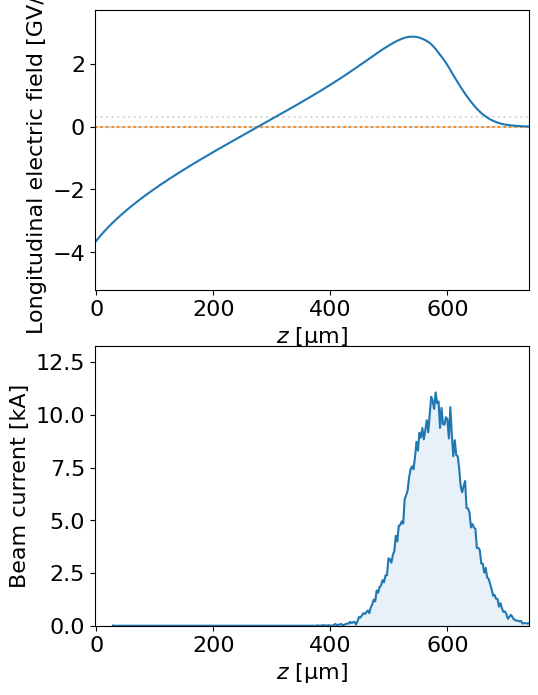

In [49]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

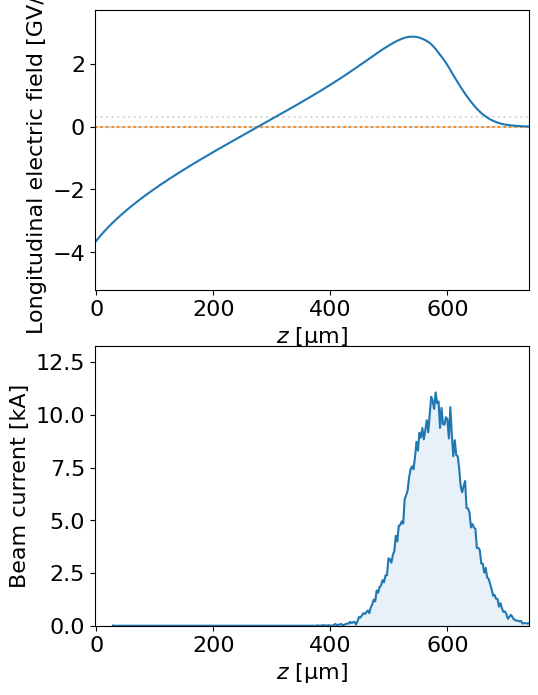

In [50]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

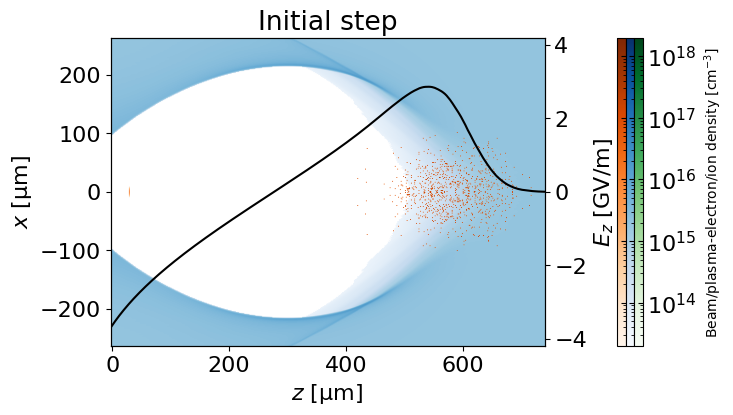

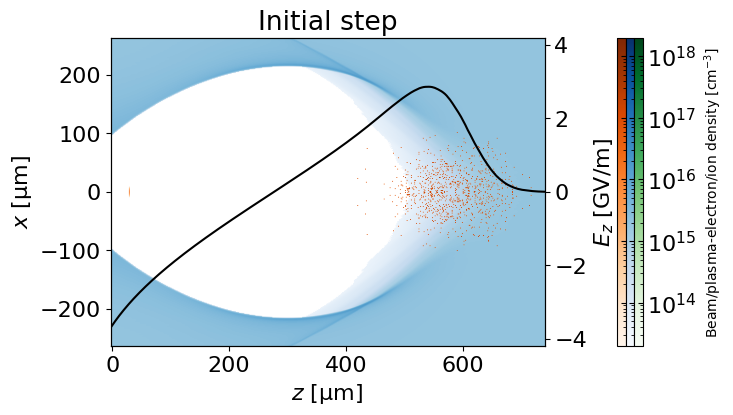

In [57]:
wake0 = linac.stages[0].plot_wake()
wake_final = linac.stages[-1].plot_wake()
#wake0.savefig(f'Plots/New_Params/wake_0_new_params_RR_{stage.enable_radiation_reaction}_10TeV.png',\
             bbox_inches = 'tight')
#if linac.num_stages < 17:
#    wake0.savefig(f'Plots/New_Params/wake0_new_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', bbox_inches='tight')
#    wake_final.savefig(f'Plots/New_Params/wake_final_new_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', bbox_inches='tight')
#else:
#    wake_final.savefig(f'Plots/New_Params/wake_final_new_params_RR_{stage.enable_radiation_reaction}_stages_{linac.num_stages}', bbox_inches='tight')

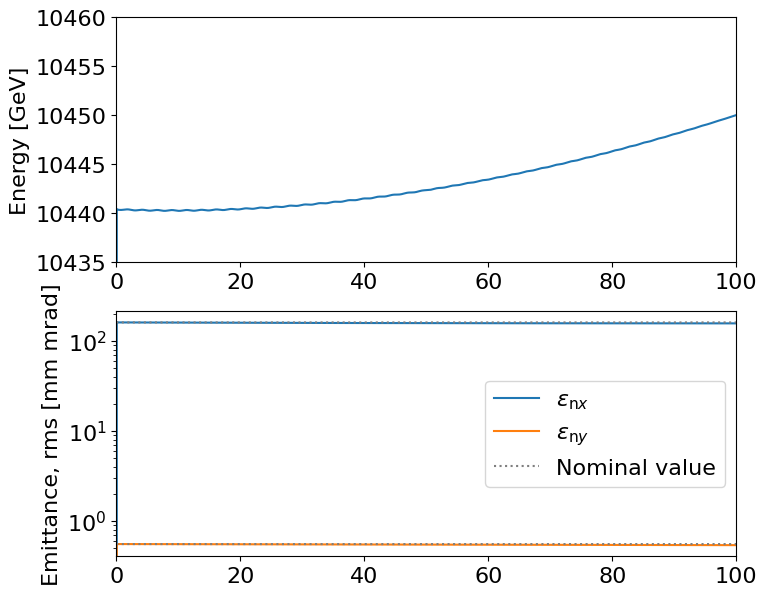

In [62]:
fig = linac.stages[0].plot_evolution()
#fig_last = linac.stages[-1].plot_evolution()
fig.savefig(f'Plots/small_beam_stage_evolution_{energy}_GeV.png', bbox_inches='tight')

### Plot beam evolution and survey

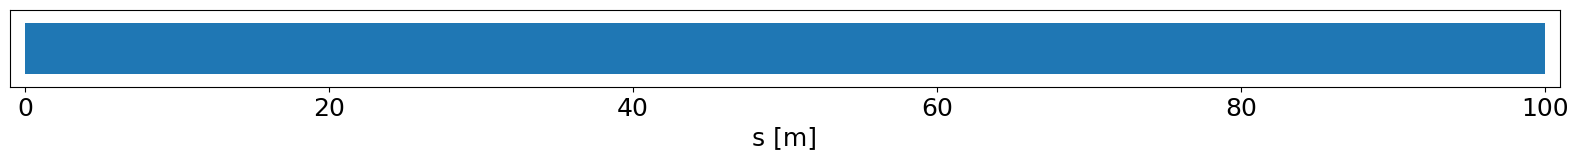

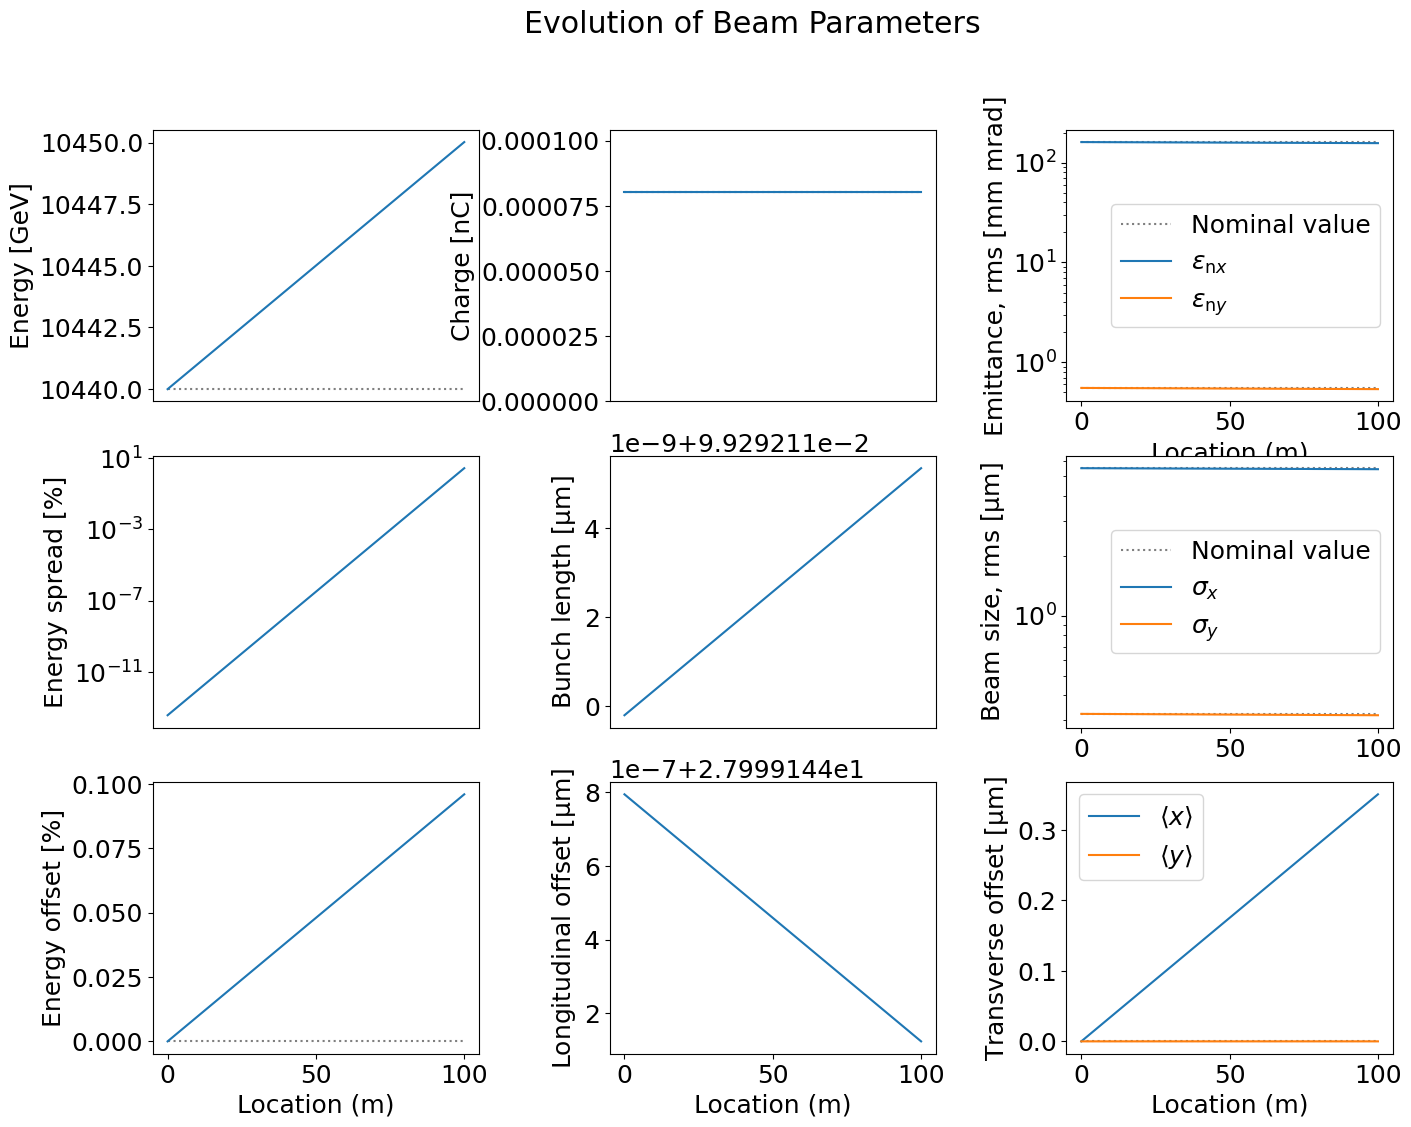

In [53]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
beam_evolution = linac.plot_evolution(use_stage_nums=False)
#beam_evolution.savefig(f"Plots/New_Params/beam_evolution_10TeV_new_params_RR_\
#{stage.enable_radiation_reaction}.png", bbox_inches = 'tight')
#linac[0].plot_waterfalls()


In [54]:
gif = linac.animate_lps()

![](run_data/linac_example/plots/lps_shot0.gif)

In [ ]:
stage_num = 15
shot_num = 0
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

In [ ]:
Final_energies = [linac.get_beam(-1, shot = i).energy()/1e9 for i in range(shots)]
Final_spread = [linac.get_beam(-1, shot = i).rel_energy_spread() for i in range(shots)]
energy_standard_error = np.std(Final_energies)
mean_energy = np.mean(Final_energies)
print('RMS energy spread is ', energy_standard_error, 'Mean final energy is ', mean_energy)

gamma = source.energy*SI.e/SI.m_e/SI.c**2
kp = pp.k_p(stage.plasma_density)
k_beta = kp/np.sqrt(2*gamma)
sig_x2 = (np.sqrt(2/gamma)*source.emit_nx/kp)
sig_y2 = (np.sqrt(2/gamma)*source.emit_ny/kp)

Expected_energy_loss = SI.e**2/6/np.pi/SI.epsilon_0 * (gamma*k_beta)**4*(sig_x2+sig_y2)*stage.length
Expected_energy_spread = SI.e**2/6/np.pi/SI.epsilon_0 * (gamma*k_beta)**4*\
np.sqrt((sig_x2**2+sig_y2**2))*stage.length/(source.energy*SI.e)

print('expected energy loss is ', Expected_energy_loss/SI.e/1e9)
print('expected energy spread is ', Expected_energy_spread)
print('actual energy spread is ', np.mean(Final_spread), \
      'standard error in energy spread is ', np.std(Final_spread))